In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance

# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

In [3]:
import max_ent.examples.grid_9_by_9 as G
from max_ent.gridworld import Directions
%matplotlib notebook
np.random.seed(123)

In [4]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=8, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal)
    vmin = -50
    vmax = 10
    G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)   
    return n, n_cfg, demo

# Nominal world

<IPython.core.display.Javascript object>


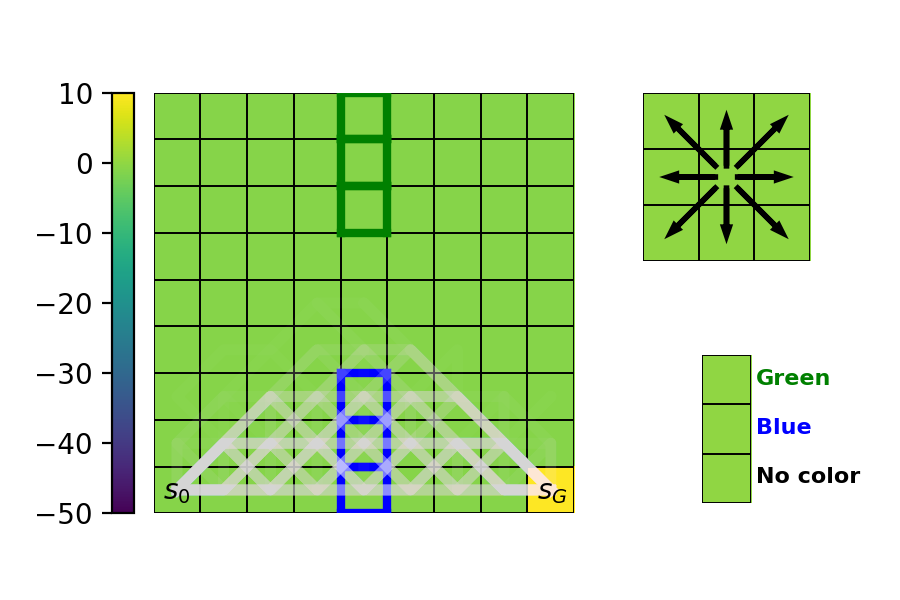

In [5]:
blue = [4, 13, 22]  # blue states
green = [58, 67, 76]  # green states

n, n_cfg, demo_n = create_world('Nominal', blue, green)

## Constrained world

<IPython.core.display.Javascript object>


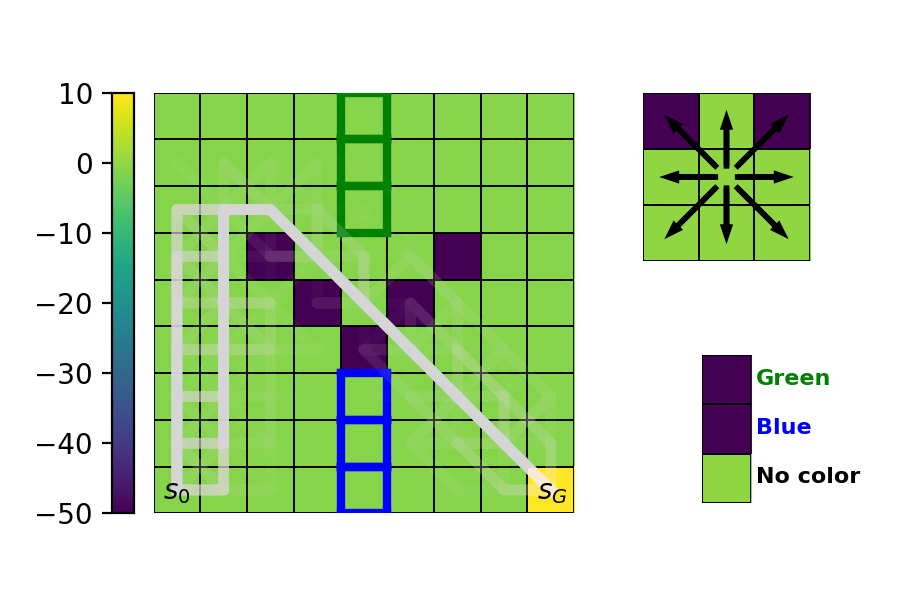

In [6]:
cs = [31, 39, 41, 47, 51]  # constrained states
ca = [Directions.UP_LEFT, Directions.UP_RIGHT]  # constrained actions
cc = [1, 2]  # constrained colors

c, c_cfg, demo_c = create_world('Constrained', blue, green, cs, ca, cc)

## Learn constraints

In [7]:
print(Directions.UP_LEFT.idx)

4


In [8]:
learned_params = G.learn_constraints(n.reward, c.world, c.terminal, demo_c.trajectories)

         1: DELTA:  0.00000, MAE:  0.496315288889989
       101: DELTA:  0.31305, MAE:  0.175528270309275
       201: DELTA:  0.22181, MAE:  0.053586313269923
       301: DELTA:  0.14176, MAE:  0.030193682221069
       401: DELTA:  0.17469, MAE:  0.028076117528057


IcyGridWorld(size=9, p_slip=0.1)
0.32


<IPython.core.display.Javascript object>


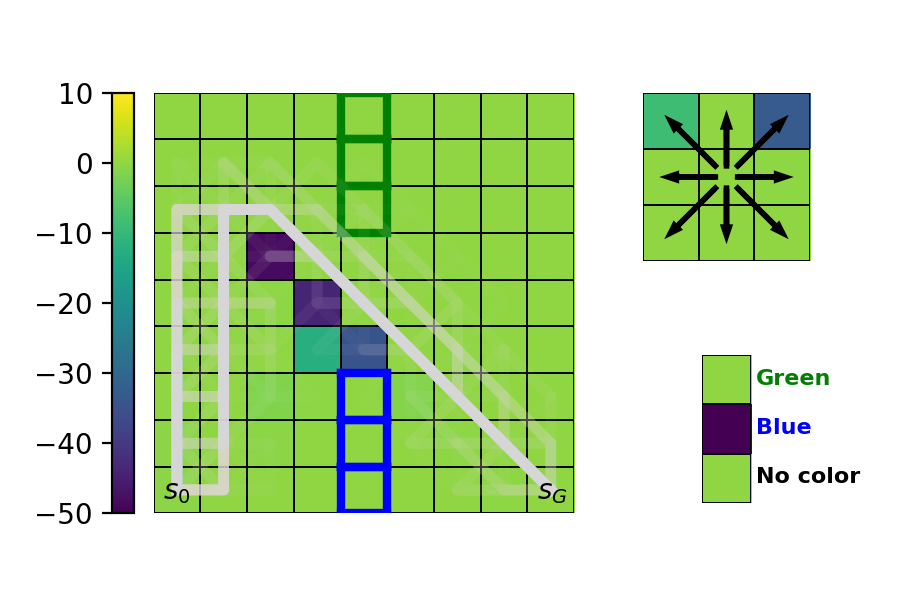

In [22]:
learned_mdp = G.MDP(c.world, learned_params.reward, c.terminal, c.start)
demo_l = G.generate_trajectories(c.world, learned_params.reward, c.start, c.terminal)

def total_reward(trajectory, world):
    reward = 0
    count_cs = 0
    count_ca = 0
    for state in trajectory.transitions():
        #check for action constraints violation
        for constraint in ca:
            if (state[1] == constraint.idx): 
                reward += -50
                count_ca += 1
                
        #check for state constraints violation
        for constraint in cs:
            if (state[0] == constraint): 
                reward += -50
                count_cs += 1
    return reward, count_cs, count_ca
        

# calculate the kl divergence
def kl_divergence(p, q):
    p = np.reshape(p, (-1,1))
    q = np.reshape(q, (-1,1))
    return sum(p[i] * math.log2(p[i]/q[i]) for i in range(len(p)))
    
# calculate the js divergence
def js_divergence(p, q):
    p = np.reshape(p, (-1,1))
    q = np.reshape(q, (-1,1))
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

#count how many times a state is visited, and compute the average length of the trajectories
def count_states(trajectories, world):
    count_matrix = np.ones((8,9,9)) * 1e-10
    avg_length = 0.0
    avg_reward = 0.0
    avg_violated = 0.0
    n = len(trajectories)
    for trajectory in trajectories:
        avg_length += len(trajectory.transitions())
        #print(trajectory)
        #print(list(trajectory.transitions()))
        reward, count_cs, count_ca = total_reward(trajectory, world)
        avg_reward += reward
        avg_violated += (count_cs + count_ca)
        for state in trajectory.states():
            #print(state)
            count_matrix[0][world.state_index_to_point(state)] += 1
            
    return count_matrix / n, avg_length / n, avg_reward / n, avg_violated / n

print(c.world)
rl_matrix, avg_rl, avg_reward, avg_violated = count_states(demo_l[0], c.world)
#print(rl_matrix[0])
print(avg_violated)
    
p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
              learned_params.action_weights, learned_params.color_weights, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

## MDFT as orchestrator

<IPython.core.display.Javascript object>


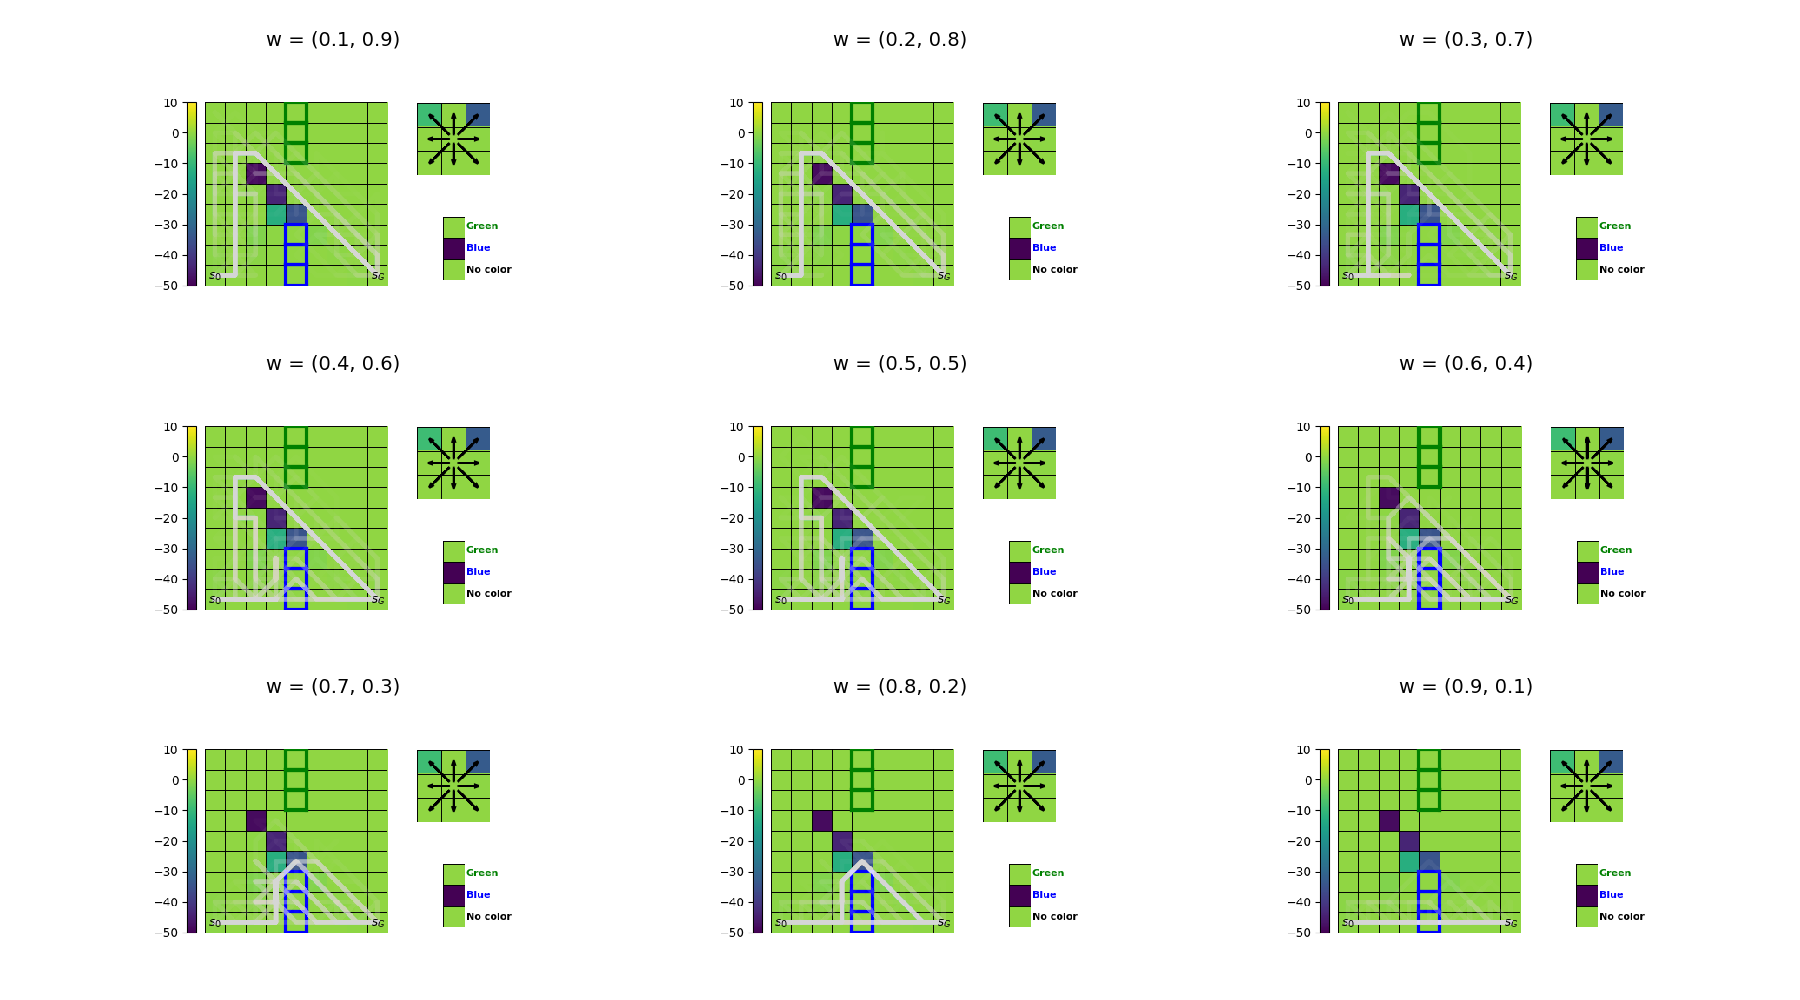

Average Length MDFT: 16.38 	 RL: 17.0 	 Reward: -11.5 	 VC: 0.23
KL(RL||MDFT) [6.73435491] 	 KL(MDFT||RL) [4.37880348]
JS(RL||MDFT) [1.01995968] 	 JS DISTANCE [0.19977496]

Average Length MDFT: 16.285 	 RL: 17.0 	 Reward: -10.75 	 VC: 0.215
KL(RL||MDFT) [7.06692655] 	 KL(MDFT||RL) [3.61346622]
JS(RL||MDFT) [1.10382248] 	 JS DISTANCE [0.20805351]

Average Length MDFT: 18.54 	 RL: 17.0 	 Reward: -12.25 	 VC: 0.245
KL(RL||MDFT) [9.92923196] 	 KL(MDFT||RL) [43.90815696]
JS(RL||MDFT) [2.50041196] 	 JS DISTANCE [0.30295141]

Average Length MDFT: 36.43 	 RL: 17.0 	 Reward: -10.25 	 VC: 0.205
KL(RL||MDFT) [24.72206398] 	 KL(MDFT||RL) [670.59443008]
JS(RL||MDFT) [15.19428842] 	 JS DISTANCE [0.61217893]

Average Length MDFT: 36.95 	 RL: 17.0 	 Reward: -12.75 	 VC: 0.255
KL(RL||MDFT) [61.22398154] 	 KL(MDFT||RL) [710.84984911]
JS(RL||MDFT) [16.23308772] 	 JS DISTANCE [0.6308071]

Average Length MDFT: 32.155 	 RL: 17.0 	 Reward: -20.25 	 VC: 0.405
KL(RL||MDFT) [122.10153546] 	 KL(MDFT||RL) [676.98

In [23]:
fig = plt.figure(figsize=(9, 5))
axis = fig.subplots(3, 3)
for i in range(9):
    w = [(i+1)/10, 1 - (i+1)/10]
    demo_mdft = G.generate_mdft_trajectories(n.world, n.reward, learned_params.reward, n.start, n.terminal, w)
    #print(len(demo_mdft))
    mdft_matrix, avg_mdft, avg_reward, avg_violated = count_states(demo_mdft[0], n.world)
    #print(mdft_matrix[0])
    p = np.reshape(rl_matrix[0], (-1,1))
    q = np.reshape(mdft_matrix[0], (-1,1))
    print(f"Average Length MDFT: {avg_mdft} \t RL: {avg_rl} \t Reward: {avg_reward} \t VC: {avg_violated}")
    print(f"KL(RL||MDFT) {kl_divergence(rl_matrix[0], mdft_matrix[0])} \t KL(MDFT||RL) {kl_divergence(mdft_matrix[0], rl_matrix[0])}")
    print(f"JS(RL||MDFT) {js_divergence(rl_matrix[0], mdft_matrix[0])} \t JS DISTANCE {distance.jensenshannon(p,q)}\n")
    
    plt.ioff()
    f1 = G.plot_world(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', learned_mdp, learned_params.state_weights, 
                  learned_params.action_weights, learned_params.color_weights, 
                  demo_mdft, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    plt.close()
    plt.ion()
    canvas = FigureCanvas(f1)
    canvas.draw()
    X = np.array(canvas.renderer.buffer_rgba())
    
    x = i // 3
    y = i % 3
    axis[x,y].axis('off')   
    axis[x,y].set_title(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', fontsize=7)
    axis[x,y].imshow(X)
    
    
fig.tight_layout()